In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'


### Mitsubishi Models: MSZ-GL18NA vs MSZ-FH18NA (low temp model)


![alt text](std.png "std")

In [2]:
# manually copying data from spec sheet
std_rated = [25000, 14000]
std_rated_power_inputs = [1.75, 2.12]
std_temp = [47, 17]

![alt text](h2i.png "h2i")

In [3]:
# manually copying data from spec sheet
h2i_rated = [25000, 14000]
h2i_rated_power_inputs = [1.72, 1.62]
h2i_temp = [47, 17]

# Conversions

COP = Output Capacity / Power Input = (BTU/hr) / (Watt)

1 kW = 3412 BTU

TPC = total power consumption in kWh

TC = BTU / hr = heating capacity

COP = TC / (TPC * 3.412) = (BTU/hr) / (kW/hr * 3.412 BTU/kw)

Cost per 15k BTU = (15 kBTU / (COP * 3.412 BTU/kW)) * price_per_kwh

max_capacity_kw = max_capacity_btu / 3412
cop = max_capacity_kw / max_power_input

## calculate COP from provided data

In [4]:
# converting rated output and rated power consumption to calculate coefficient of performance (cop not in manual)
std_cop = [round(std_rated[i] / (3412 * std_rated_power_inputs[i]), 2) for i in range(len(std_rated))]
dat = list(zip(std_temp, std_cop, std_rated))
std_dat = pd.DataFrame(dat, columns = ['temp', 'COP', 'rated_btu'])
std_dat

,temp,COP,rated_btu
0,47,4.19,25000
1,17,1.94,14000


In [5]:
# converting rated output and rated power consumption to calculate coefficient of performance (cop not in manual)
h2i_cop = [round(h2i_rated[i] / (3412 * h2i_rated_power_inputs[i]), 2) for i in range(len(h2i_rated))]
dat = list(zip(h2i_temp, h2i_cop, h2i_rated))
h2i_dat = pd.DataFrame(dat, columns = ['temp', 'COP', 'rated_btu'])
h2i_dat

,temp,COP,rated_btu
0,47,4.26,25000
1,17,2.53,14000


## view COP curves

Text(0.5, 1.0, 'COP for Standard vs Hyper Heat')

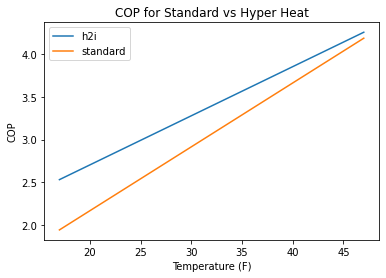

In [6]:
plt.plot(h2i_dat.temp, h2i_dat.COP)
plt.plot(std_dat.temp, std_dat.COP)
plt.xlabel('Temperature (F)')
plt.ylabel('COP')
plt.legend(['h2i', 'standard'])
plt.title('COP for Standard vs Hyper Heat')

## assuming COP linear in range given in spec sheet, find eq. describing COP

In [7]:
from numpy.linalg import inv
A = np.array([[47., 1.], [17., 1.]])
A_inv = inv(A)

In [8]:
# solve system of eqs for gl COP parameters
std_b = std_dat.COP.values
std_params = A_inv.dot(std_b)

In [9]:
# solve system of eqs for fh COP parameters
h2i_b = h2i_dat.COP.values
h2i_params = A_inv.dot(h2i_b)

## analyze costs

- assume heating turns on when outside temp is 50 degrees F

- COP data for drybulb indoor temps of 70 degrees F

In [10]:
# load data from pickle
data = pd.read_pickle('lga_min_temp_2000-2021.pkl')

In [11]:
# choose times 2010-2020
temps = data[(data.Date > '2010') & (data.Date < '2020')]

# heat on days x or below
upper_threshold = 62
too_hot = [upper_threshold] * len(temps)
lower_threshold = 5
too_cold = [lower_threshold] * len(temps)

Text(0.5, 1.0, 'Daily Minimum Temperatures 2010-2020')

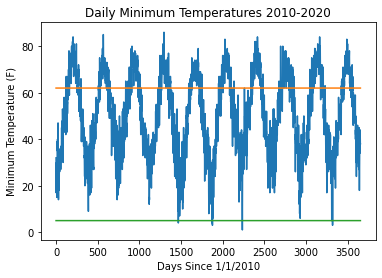

In [12]:
plt.plot(temps['Minimum Temperature'].values)
plt.plot(too_hot)
plt.plot(too_cold)
plt.xlabel('Days Since 1/1/2010')
plt.ylabel('Minimum Temperature (F)')
plt.title('Daily Minimum Temperatures 2010-2020')

In [13]:
# will not be heating on days where temp is above threshold
temps.loc[temps['Minimum Temperature'] > upper_threshold, 'Minimum Temperature'] = np.nan
temps.loc[temps['Minimum Temperature'] < lower_threshold, 'Minimum Temperature'] = np.nan

In [14]:
# calculate daily COP values

temps['std_daily_cop'] = round(std_params[0] * temps['Minimum Temperature'] + std_params[1], 2)
temps['h2i_daily_cop'] = round(h2i_params[0] * temps['Minimum Temperature'] + h2i_params[1], 2)


In [15]:
# calculate daily energy use and cost per 15kBTU of heating/hr
# 9/2021 I paid Con Edison 23 cents per kWh

cost_per_kwh = .23

heat_output = 15000
btu_to_kw = heat_output / 3412.

temps['std_daily_power_kwh'] = round(btu_to_kw / temps['std_daily_cop'] * 24, 2)
temps['h2i_daily_power_kwh'] = round(btu_to_kw / temps['h2i_daily_cop'] * 24, 2)

temps['std_daily_cost_$'] = round(temps['std_daily_power_kwh'] * cost_per_kwh, 2)
temps['h2i_daily_cost_$'] = round(temps['h2i_daily_power_kwh'] * cost_per_kwh, 2)

In [16]:
temps

,Date,Minimum Temperature,Station,std_daily_cop,h2i_daily_cop,std_daily_power_kwh,h2i_daily_power_kwh,std_daily_cost_$,h2i_daily_cost_$
3653,2010-01-01,32.0,GHCND:USW00014732,3.07,3.39,34.37,31.12,7.91,7.16
3654,2010-01-02,17.0,GHCND:USW00014732,1.94,2.53,54.39,41.70,12.51,9.59
3655,2010-01-03,18.0,GHCND:USW00014732,2.02,2.59,52.23,40.74,12.01,9.37
3656,2010-01-04,21.0,GHCND:USW00014732,2.24,2.76,47.10,38.23,10.83,8.79
3657,2010-01-05,22.0,GHCND:USW00014732,2.32,2.82,45.48,37.41,10.46,8.60
...,...,...,...,...,...,...,...,...,...
7300,2019-12-27,42.0,GHCND:USW00014732,3.82,3.97,27.62,26.58,6.35,6.11
7301,2019-12-28,44.0,GHCND:USW00014732,3.97,4.09,26.58,25.80,6.11,5.93
7302,2019-12-29,38.0,GHCND:USW00014732,3.52,3.74,29.97,28.21,6.89,6.49
7303,2019-12-30,38.0,GHCND:USW00014732,3.52,3.74,29.97,28.21,6.89,6.49


In [17]:
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

yearly_cost_std = [(val, round(np.nansum(temps[(temps.Date > years[idx]) & 
                                               (temps.Date < years[idx+1])]['std_daily_cost_$']), 2))
                   for idx, val in enumerate(years[:-1])] 

yearly_cost_h2i = [(val, round(np.nansum(temps[(temps.Date > years[idx]) & 
                                               (temps.Date < years[idx+1])]['h2i_daily_cost_$']), 2))
                   for idx, val in enumerate(years[:-1])] 

In [18]:
# convert to dict
cost_std = {}
for item in yearly_cost_std:
    year = item[0]
    cost_std[year] = item[1]

In [19]:
cost_h2i = {}
for item in yearly_cost_h2i:
    year = item[0]
    cost_h2i[year] = item[1]

## Plot savings

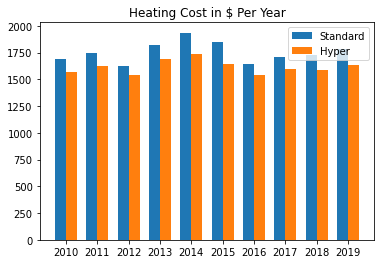

In [20]:
fig, ax = plt.subplots()

ind = np.arange(len(years[:-1]))    # the x locations for the groups
width = 0.35         # the width of the bars

ax.bar(ind, cost_std.values(), width, label='Standard')

ax.bar(ind + width, cost_h2i.values(), width,
       label='Hyper')

ax.set_title('Heating Cost in $ Per Year')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(years[:-1])

ax.legend()
ax.autoscale_view()

plt.show()

In [21]:
savings = np.array(list(cost_std.values())) - np.array(list(cost_h2i.values()))

<ipython-input-22-dc4da6ebba84>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(years[:-1])


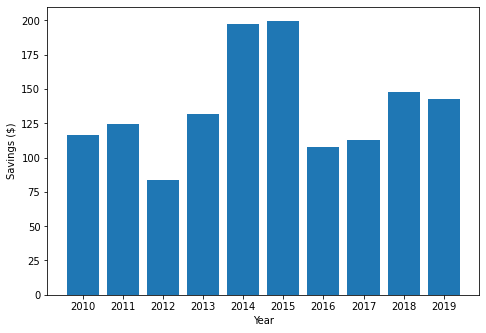

In [22]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(years[:-1], savings)
ax.set_xticklabels(years[:-1])
ax.set_ylabel('Savings ($)')
ax.set_xlabel('Year')
plt.show()